Seyed Mohsen Sadeghi 99222059

here we will import necessary libraries

In [ ]:
import  matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms.transforms as  transforms

import torch.nn as nn
import torch.nn.functional as functions
import torch.optim as optim

from tqdm import tqdm


The loaders are supposed to load the data from the internet (load will load the data as it is but in load_with_batch we will get the data normalized)

In [59]:
train_loader = None
test_loader = None

def load():
    global train_loader, test_loader
    transform = transforms.Compose([transforms.ToTensor()])

    train_data = torchvision.datasets.FashionMNIST('data', download=True, train=True, transform=transform)
    test_data  = torchvision.datasets.FashionMNIST('data', download=True, train=False, transform=transform)


    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=10)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=5)



def load_with_batch():
    global train_loader, test_loader


    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, ), (0.5, ))])

    train_data = torchvision.datasets.FashionMNIST('data', download=True, train=True, transform=transform)
    test_data  = torchvision.datasets.FashionMNIST('data', download=True, train=False, transform=transform)


    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=10)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=5)


here is our model which is consist of 5 layers

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = functions.relu(self.fc1(x))
        x = functions.relu(self.fc2(x))
        x = functions.relu(self.fc3(x))
        x = functions.relu(self.fc4(x))
        x = functions.log_softmax(self.fc5(x), dim=1)

        return x


here our model is still 5 layers but with a dropout layer

In [61]:
class Classifier_With_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        dropout = nn.Dropout(p=0.2)
        x = x.view(x.shape[0], -1)
        x = functions.relu(self.fc1(x))
        x = dropout(x)
        x = functions.relu(self.fc2(x))
        x = functions.relu(self.fc3(x))
        x = functions.relu(self.fc4(x))
        x = functions.log_softmax(self.fc5(x), dim=1)

        return x

In [62]:
def plot(data, label_):
    plt.plot(data, label=label_)
    plt.title(label_)
    plt.grid(True)
    plt.show()


the bellow methods is built for training the model by giving it epochs and the l2_norm, also we have an accuracy stop which tells our model to stop when it reaches the wanted accuracy
 by deadult the value is 1 (100%)

In [63]:
def train(model, epochs, l2_norm=0, accuracy_stop=1):

    train_losses, test_losses = [], []
    accuracy_list = []
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=l2_norm)

    for e in tqdm(range(epochs)):
        running_loss = 0
        for image, label in train_loader:
            image = image.view(image.shape[0], -1)

            optimizer.zero_grad()

            output = model.forward(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        else:
            test_loss = 0
            accuracy = 0

            with torch.no_grad():
                model.eval()

                for image, label in test_loader:
                    image = image.view(image.shape[0], -1)
                    log_ps = model(image)
                    test_loss += criterion(log_ps, label)

                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)

                    equals = top_class == label.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
        accuracy = accuracy/len(test_loader)

        accuracy_list.append(accuracy)
        if accuracy >= accuracy_stop:
            break
        model.train()
        train_losses.append(running_loss/ len(train_loader))
        test_losses.append(test_loss/len(test_loader))

    plot(accuracy_list, "accuracy")
    plot(train_losses, "Training loss")
    plot(test_losses, "Validation loss")

    print('best accuracy: ' + str(max(accuracy_list)))


100%|██████████| 30/30 [07:22<00:00, 14.77s/it]


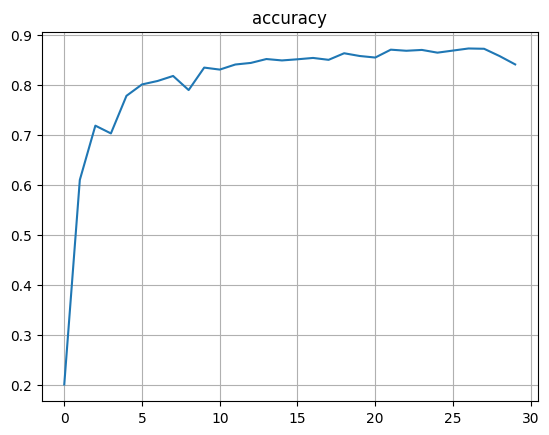

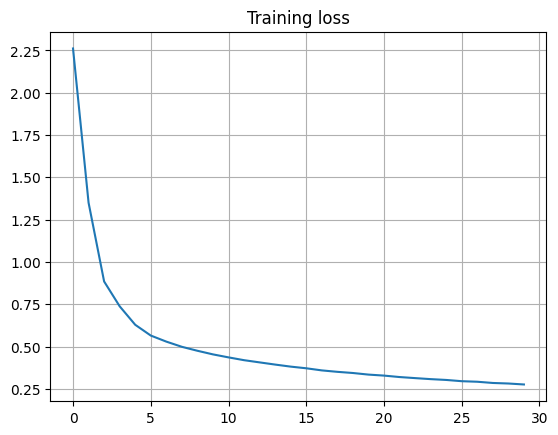

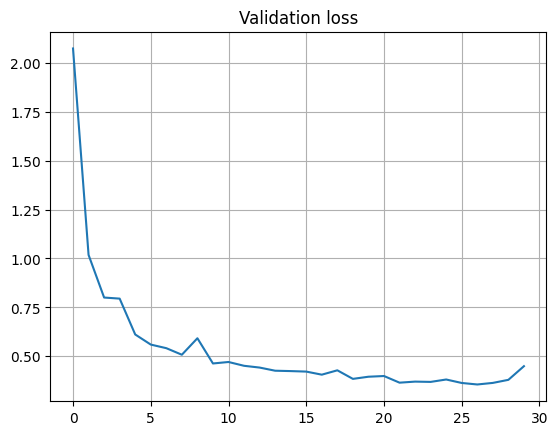

In [50]:
load()
model = Classifier()
train(model, epochs=30)


100%|██████████| 30/30 [05:46<00:00, 11.55s/it]


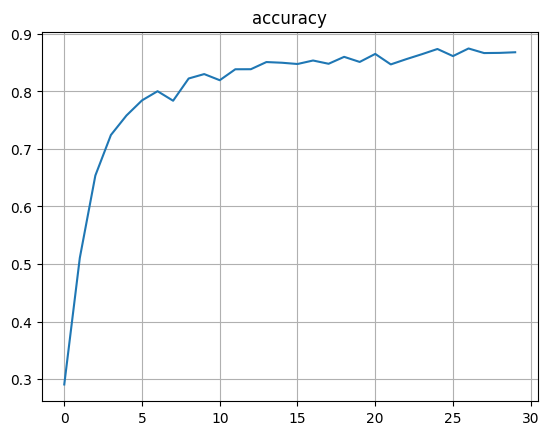

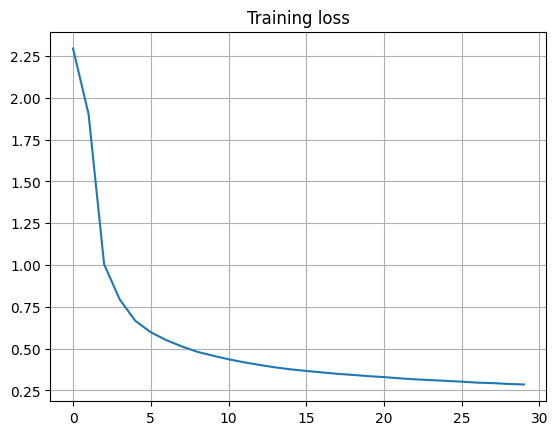

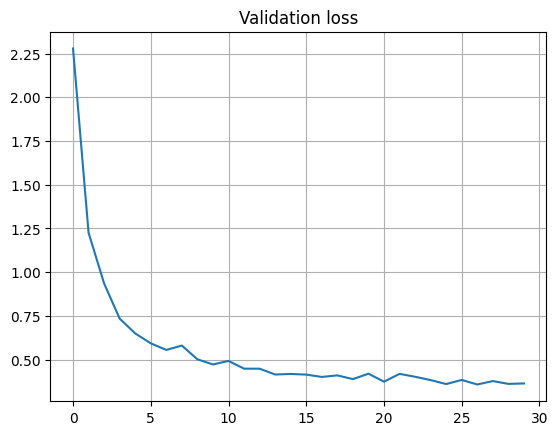

In [51]:
load()
model = Classifier_With_dropout()
train(model, epochs=30)

100%|██████████| 30/30 [07:13<00:00, 14.44s/it]


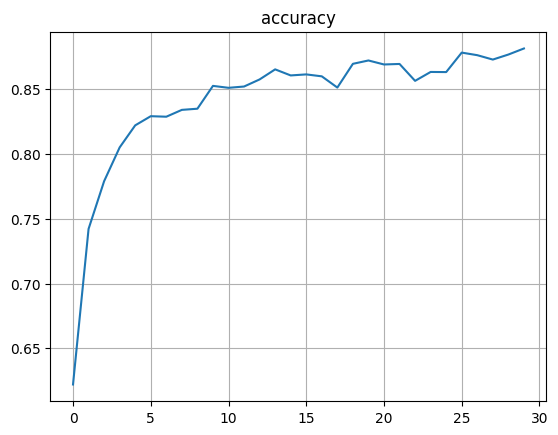

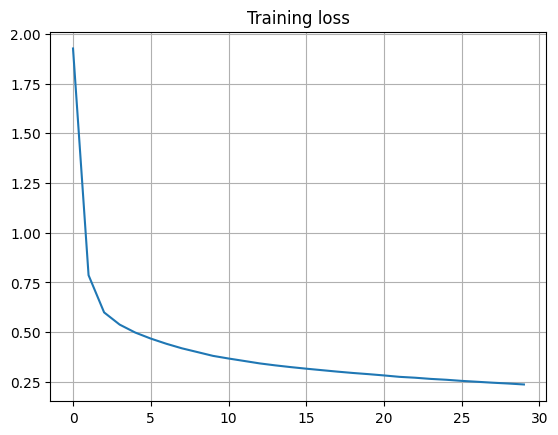

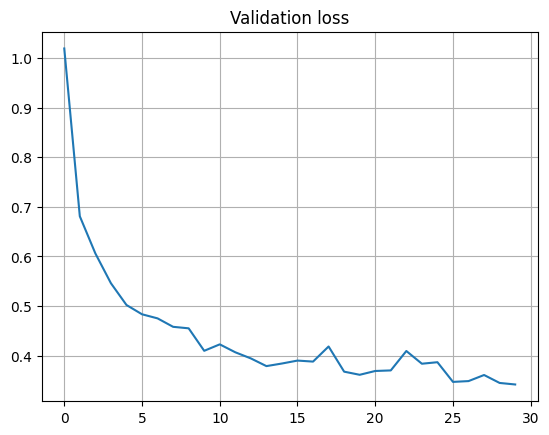

In [52]:
load_with_batch()
model = Classifier()
train(model, epochs=30)

100%|██████████| 30/30 [06:27<00:00, 12.91s/it]


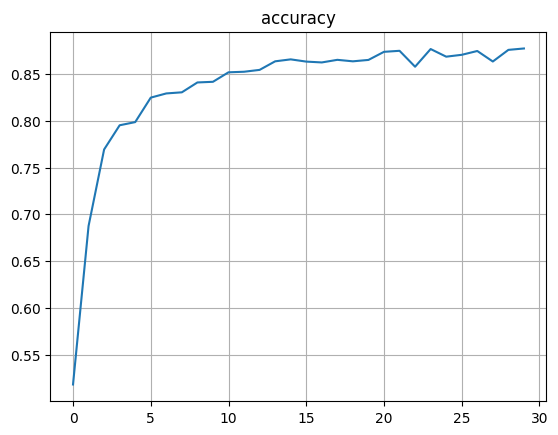

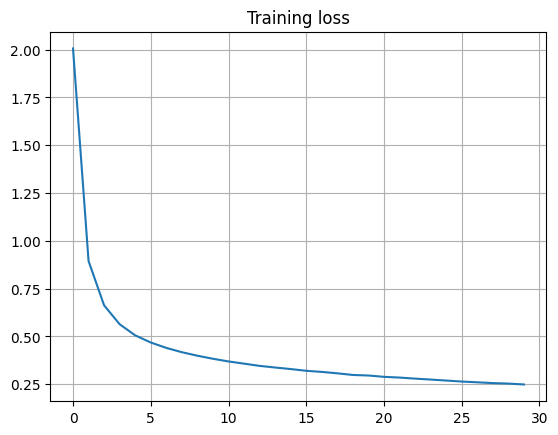

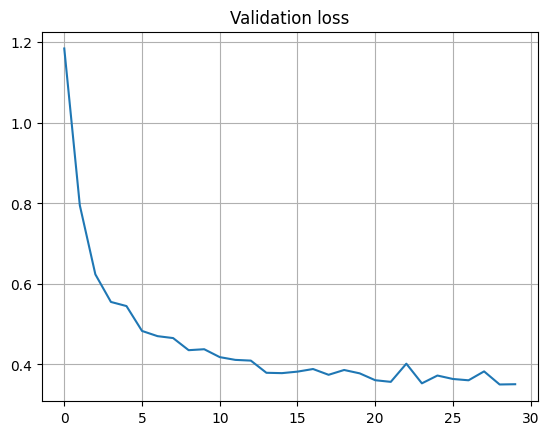

In [53]:
load_with_batch()
model = Classifier_With_dropout()
train(model, epochs=30)

As it can be seen from the above graphs the best model we possess currently is the one where we use batch regularization and dropout technique together
Now let's add a few more layers to it see the effect of adding hidden layers

In [55]:
class Classifier_With_dropout_more_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)


    def forward(self, x):
        dropout = nn.Dropout(p=0.2)
        x = x.view(x.shape[0], -1)
        x = functions.relu(self.fc1(x))
        x = dropout(x)
        x = functions.relu(self.fc2(x))
        x = functions.relu(self.fc3(x))
        x = dropout(x)
        x = functions.relu(self.fc4(x))
        x = functions.relu(self.fc5(x))
        x = functions.log_softmax(self.fc6(x), dim=1)

        return x

100%|██████████| 30/30 [07:04<00:00, 14.15s/it]


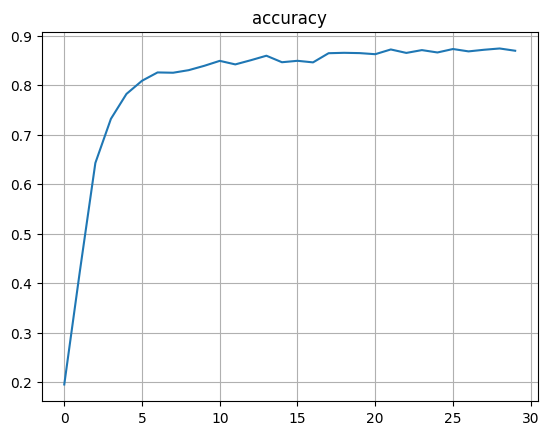

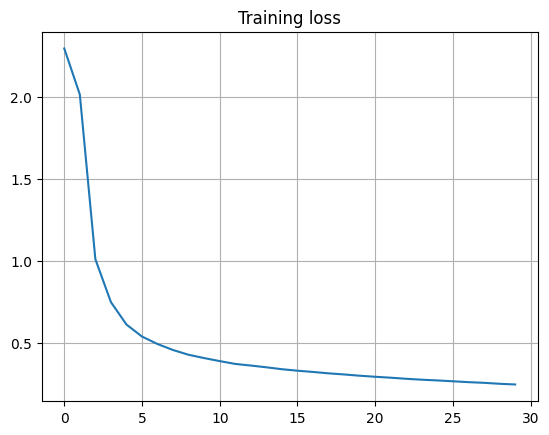

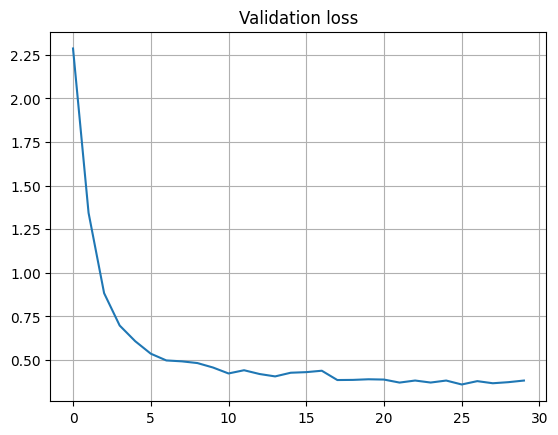

In [56]:
load_with_batch()
model = Classifier_With_dropout_more_layers()
train(model, epochs=30)

As it can be seen in the graphs adding more layers actually made our model preform worse, so we will go back to our previous model and give l2 a value of 0.001

100%|██████████| 30/30 [05:54<00:00, 11.82s/it]


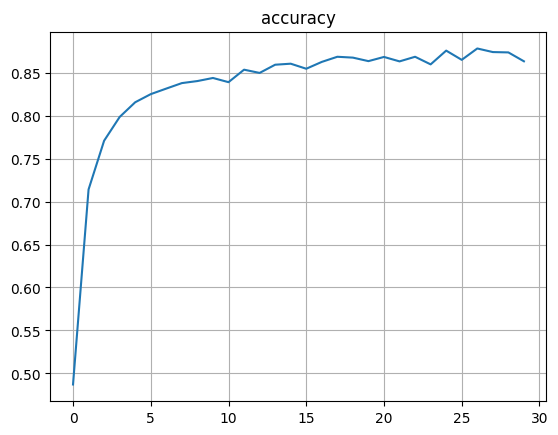

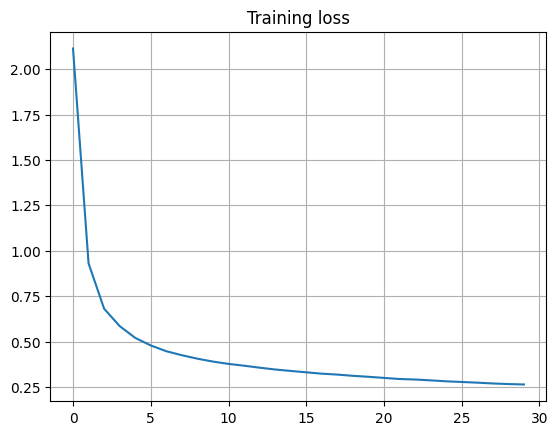

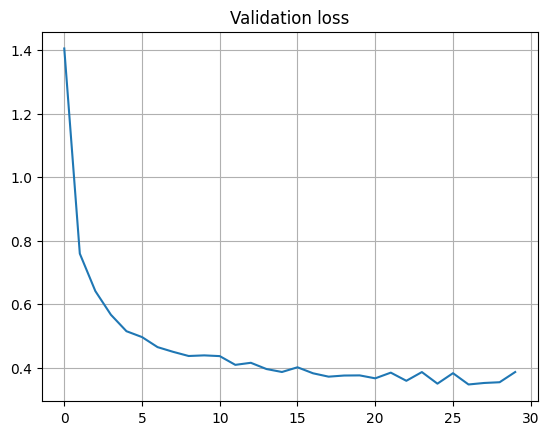

best accuracy: tensor(0.8782)


In [64]:
load_with_batch()
model = Classifier_With_dropout()
train(model, epochs=30, l2_norm=0.001)

adding l2 didn't help our model either maybe by changing its value we will get a better model but that will take a lot of time to run and the deadline is close